In [16]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [133]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import re
from wordcloud import WordCloud, STOPWORDS
# from word_cloud.word_cloud_generator import WordCloud
from matplotlib import rcParams
import operator

In [18]:
import warnings
warnings.filterwarnings('ignore')

# user.json

See older versions of the file to retrieve the code!

# CSV file from 'business.json'

In [19]:
# Reading in 'extacted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [20]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [21]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


# CSV file from 'review.json'

In [22]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [23]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"}).head()

Index_From_review.JSON               review_id             business_id  \
0                      3  yi0R0Ugj_xUx_Nek0-_Qig  ikCg8xy5JIg_NGPx-MSIDA   
1                      5  fdiNeiN_hoCxCMy2wTRW9g  eU_713ec6fTGNO4BegRaww   
2                      6  G7XHMxG0bx9oBJNECG4IFg  3fw2X5bZYeW9xCz_zGhOHg   
3                      7  8e9HxxLjjqc9ez5ezzN7iQ  zvO-PJCpNk4fgAVUnExYAA   
4                     10  kbtscdyz6lvrtGjD1quQTg  8mIrX_LrOnAqWsB5JrOojQ   

   stars                                               text  
0    5.0  Went in for a lunch. Steak sandwich was delici...  
1    4.0  I'll be the first to admit that I was not exci...  
2    3.0  Tracy dessert had a big name in Hong Kong and ...  
3    1.0  This place has gone down hill.  Clearly they h...  
4    4.0  Like walking back in time, every Saturday morn...

# Modeling

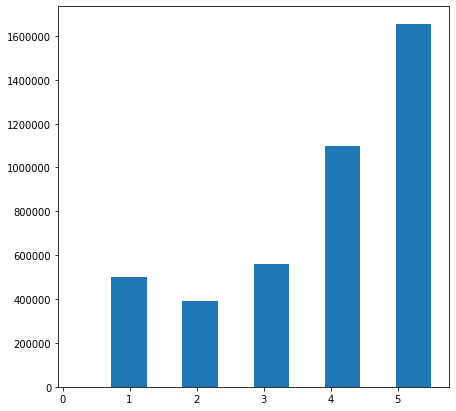

In [24]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, range = (0.2,5.5), bins = 10)
plt.show()

In [25]:
# Random EDA
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))
testset = rest_review_csvTOpd[:1000]
category = testset.stars
testset.head()

There are 4201685 restaurant reviews.


Unnamed: 0               review_id             business_id  stars  \
0          3  yi0R0Ugj_xUx_Nek0-_Qig  ikCg8xy5JIg_NGPx-MSIDA    5.0   
1          5  fdiNeiN_hoCxCMy2wTRW9g  eU_713ec6fTGNO4BegRaww    4.0   
2          6  G7XHMxG0bx9oBJNECG4IFg  3fw2X5bZYeW9xCz_zGhOHg    3.0   
3          7  8e9HxxLjjqc9ez5ezzN7iQ  zvO-PJCpNk4fgAVUnExYAA    1.0   
4         10  kbtscdyz6lvrtGjD1quQTg  8mIrX_LrOnAqWsB5JrOojQ    4.0   

                                                text  
0  Went in for a lunch. Steak sandwich was delici...  
1  I'll be the first to admit that I was not exci...  
2  Tracy dessert had a big name in Hong Kong and ...  
3  This place has gone down hill.  Clearly they h...  
4  Like walking back in time, every Saturday morn...

In [26]:
one_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 1.0]
two_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 2.0]
three_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 3.0]
four_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 4.0]
five_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 5.0]

In [27]:
# Figuring out what percentage of the "rest_review_csvTOpd" should be training data, and what percentage should be test data.
num_train_data = int(rest_review_length * 0.8)
print("For 80% of the data, there should be {} reviews.".format(num_train_data))

For 80% of the data, there should be 3361348 reviews.


In [28]:
# Train data has equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], three_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], three_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

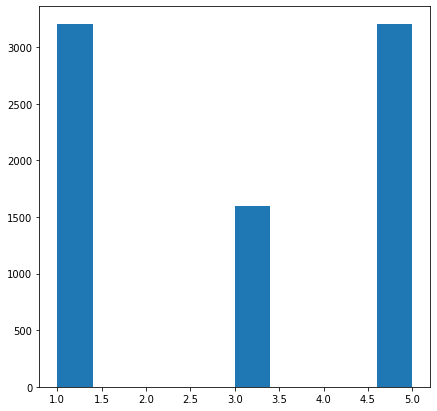

In [29]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, range = (1,5), bins = 10)
plt.show()

In [38]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
vtrain = vectorizer.fit_transform(train_data)
vtest = vectorizer.transform(test_data)

In [39]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vtest)
f1_score = metrics.f1_score(test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.7645667436311591


In [40]:
lr_classifier.predict_proba(vdev)

array([[0.95321591, 0.01361652, 0.03316756],
       [0.72909956, 0.15708661, 0.11381383],
       [0.8697856 , 0.06072605, 0.06948835],
       ...,
       [0.13702692, 0.11199388, 0.7509792 ],
       [0.07445364, 0.02312043, 0.90242593],
       [0.10455203, 0.11123606, 0.78421191]])

# Sample Prediction

In [41]:
# Predict new sentence
test_sentence = "I hate this place"
test_sentence = [test_sentence]

In [42]:
new_test = vectorizer.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.47168233, 0.172166  , 0.35615168]])

# Predictions without the neutral data

In [33]:
# Throwing away the neutral data
NO3_train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
NO3_train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

NO3_test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
NO3_test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

In [34]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
v_NO3_train = vectorizer.fit_transform(NO3_train_data)
v_NO3_test = vectorizer.transform(NO3_test_data)

In [35]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.08)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_test)
f1_score = metrics.f1_score(NO3_test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.917474726635032


* So if we throw out the moderate data (the 3-star reviews), it is clear that there is a difference between positive and negative reviews.

# Word Cloud

In [119]:
cloud_train_data = pd.concat([one_star.text[:1600], five_star.text[:1600]]).tolist()
cloud_train_labels = pd.concat([one_star.stars[:1600], five_star.stars[:1600]])

## General Word Cloud

In [216]:
stopwords = STOPWORDS

In [203]:
general = " ".join(cloud_train_data)

In [204]:
wordcloud = WordCloud(stopwords = stopwords, width=1600, height=800, max_font_size=200).generate(general)

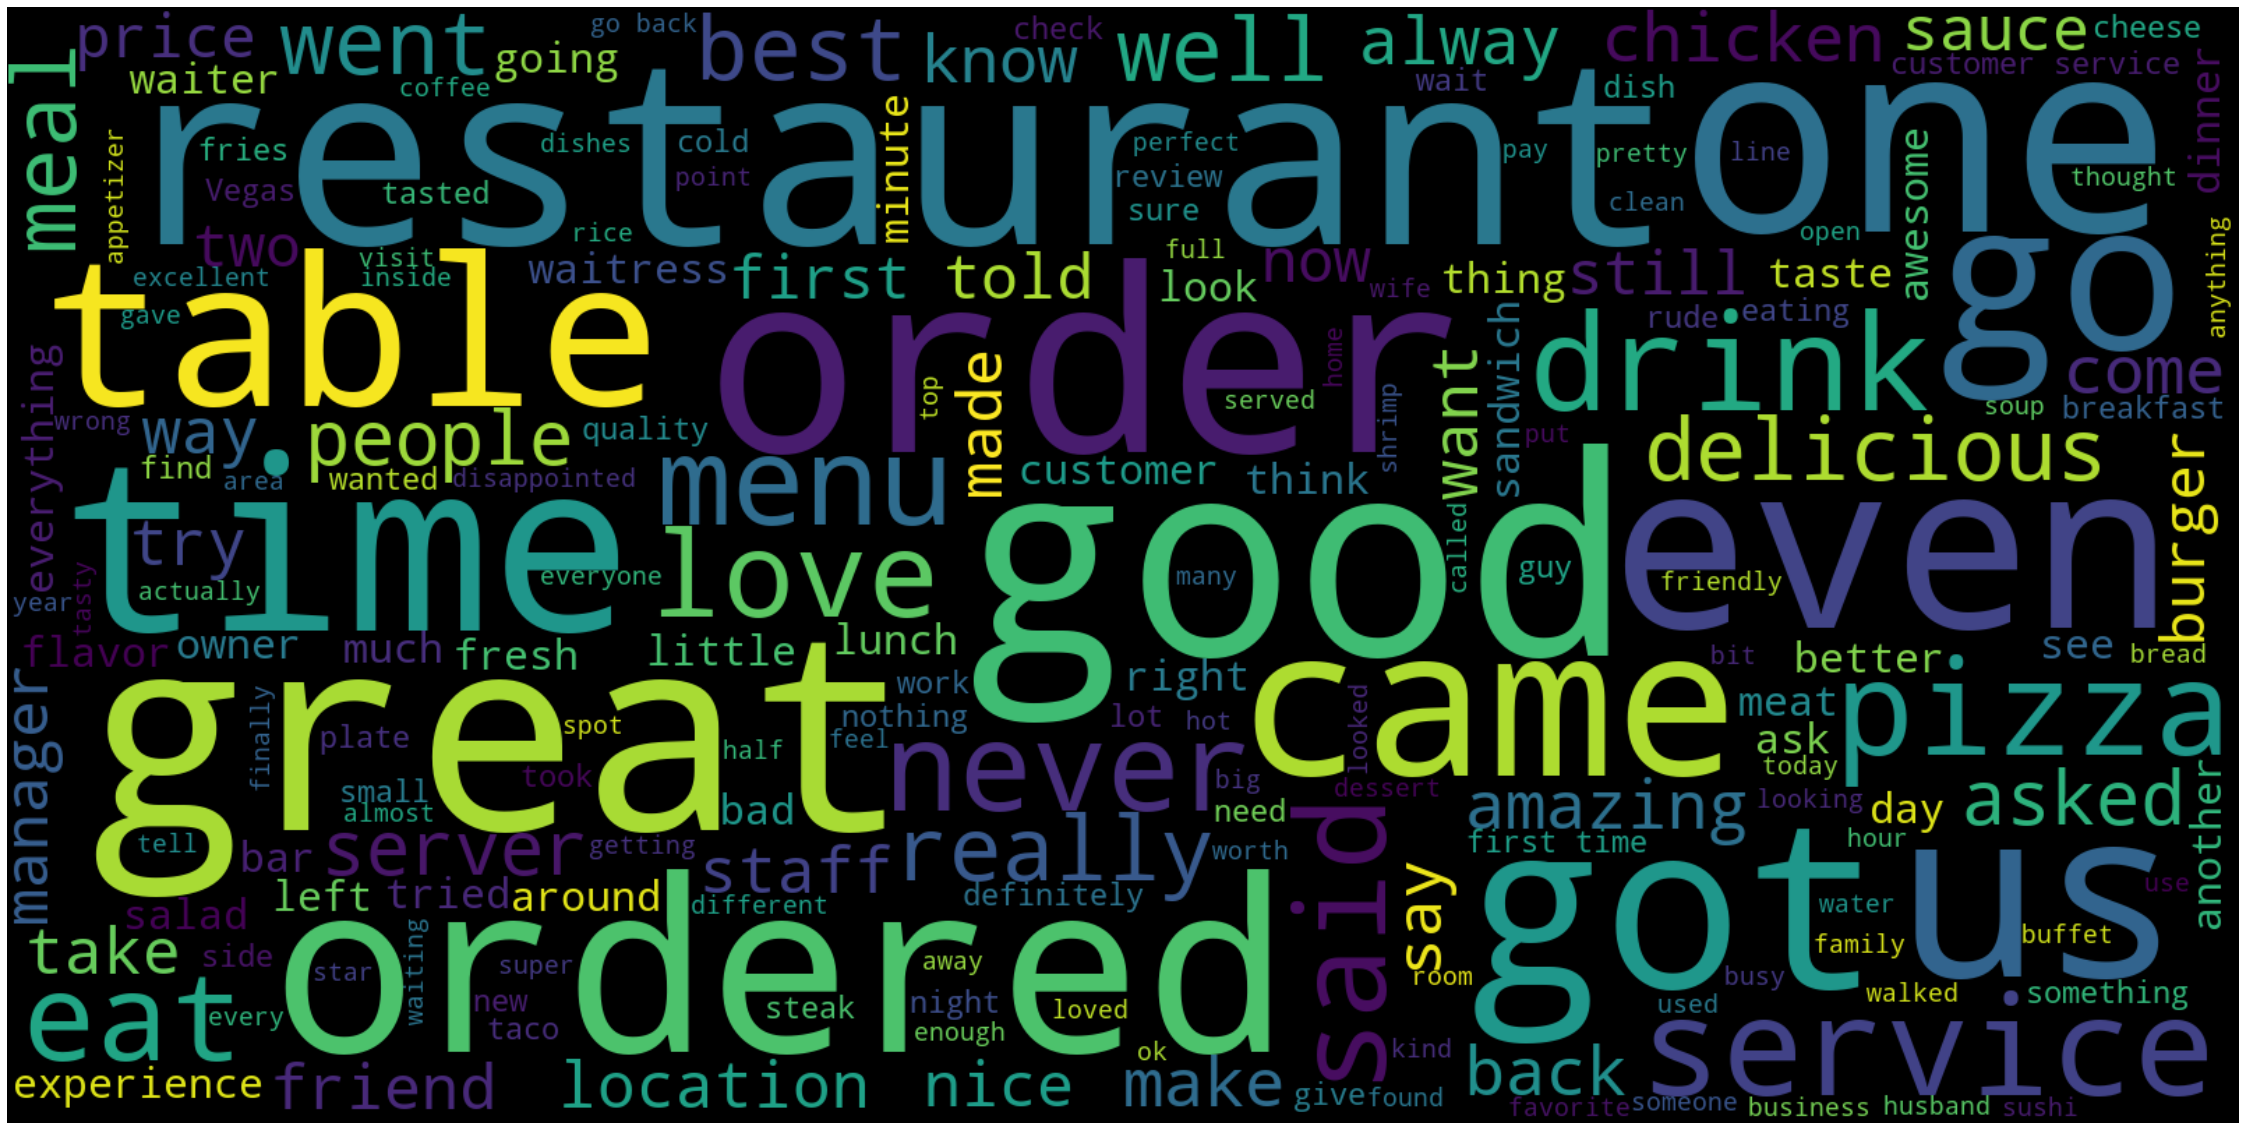

In [205]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

## General Word Cloud with Positive Reviews

In [208]:
# Positive Reviews Dataset
positive_reviews = five_star.text[1600:2000].tolist()
positive = " ".join(positive_reviews)

In [209]:
wordcloud = WordCloud(stopwords = stopwords, width=1600, height=800, max_font_size=200).generate(positive)

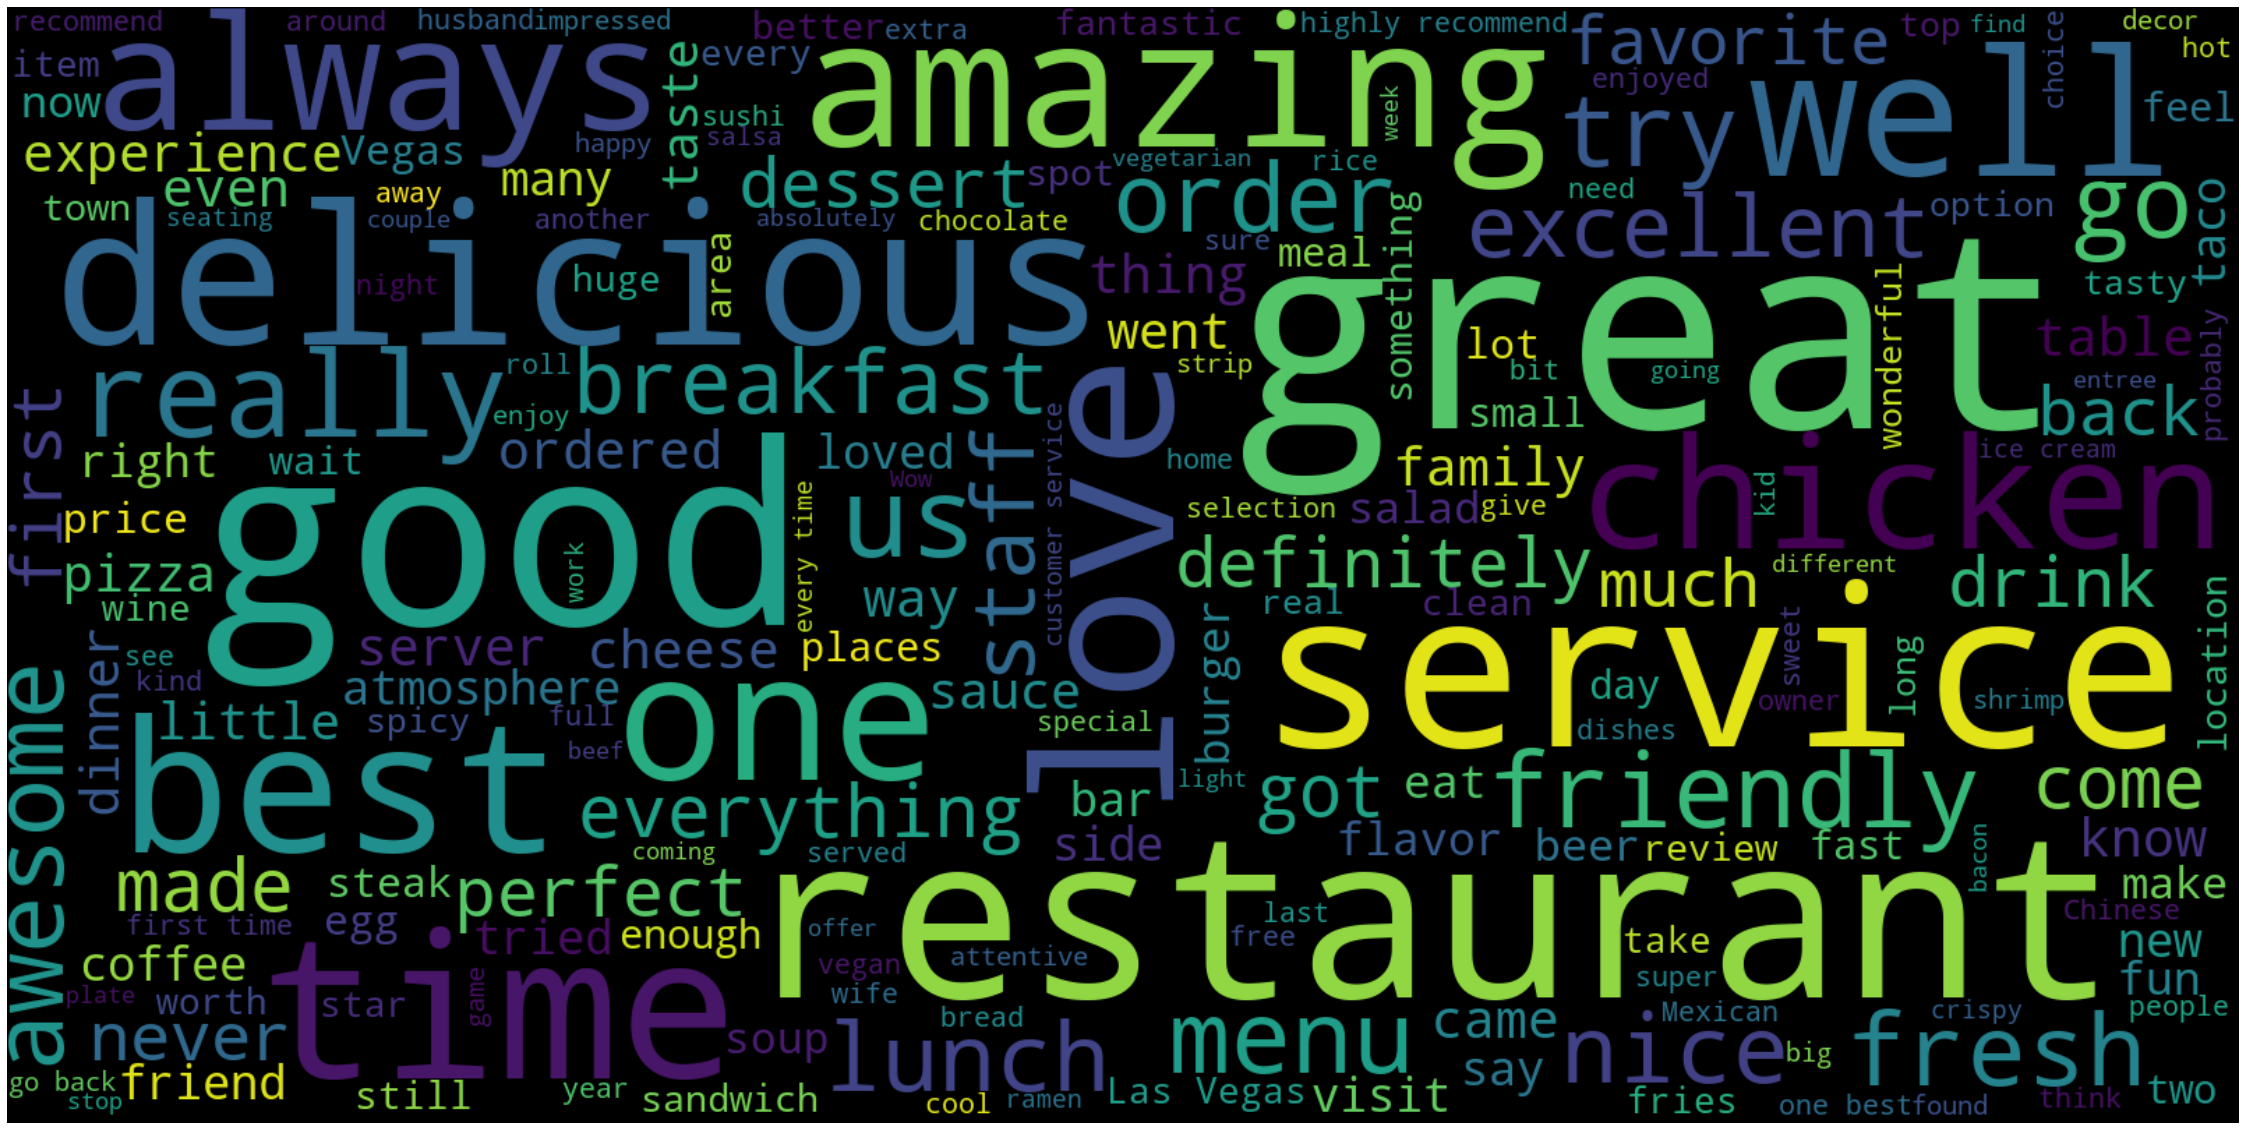

In [210]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

## General Word Cloud with Positive Reviews

In [211]:
# Negative Reviews Dataset
negative_reviews = one_star.text[1600:2000].tolist()
negative = " ".join(negative_reviews)

In [212]:
wordcloud = WordCloud(stopwords = stopwords,width=1600, height=800, max_font_size=200).generate(negative)

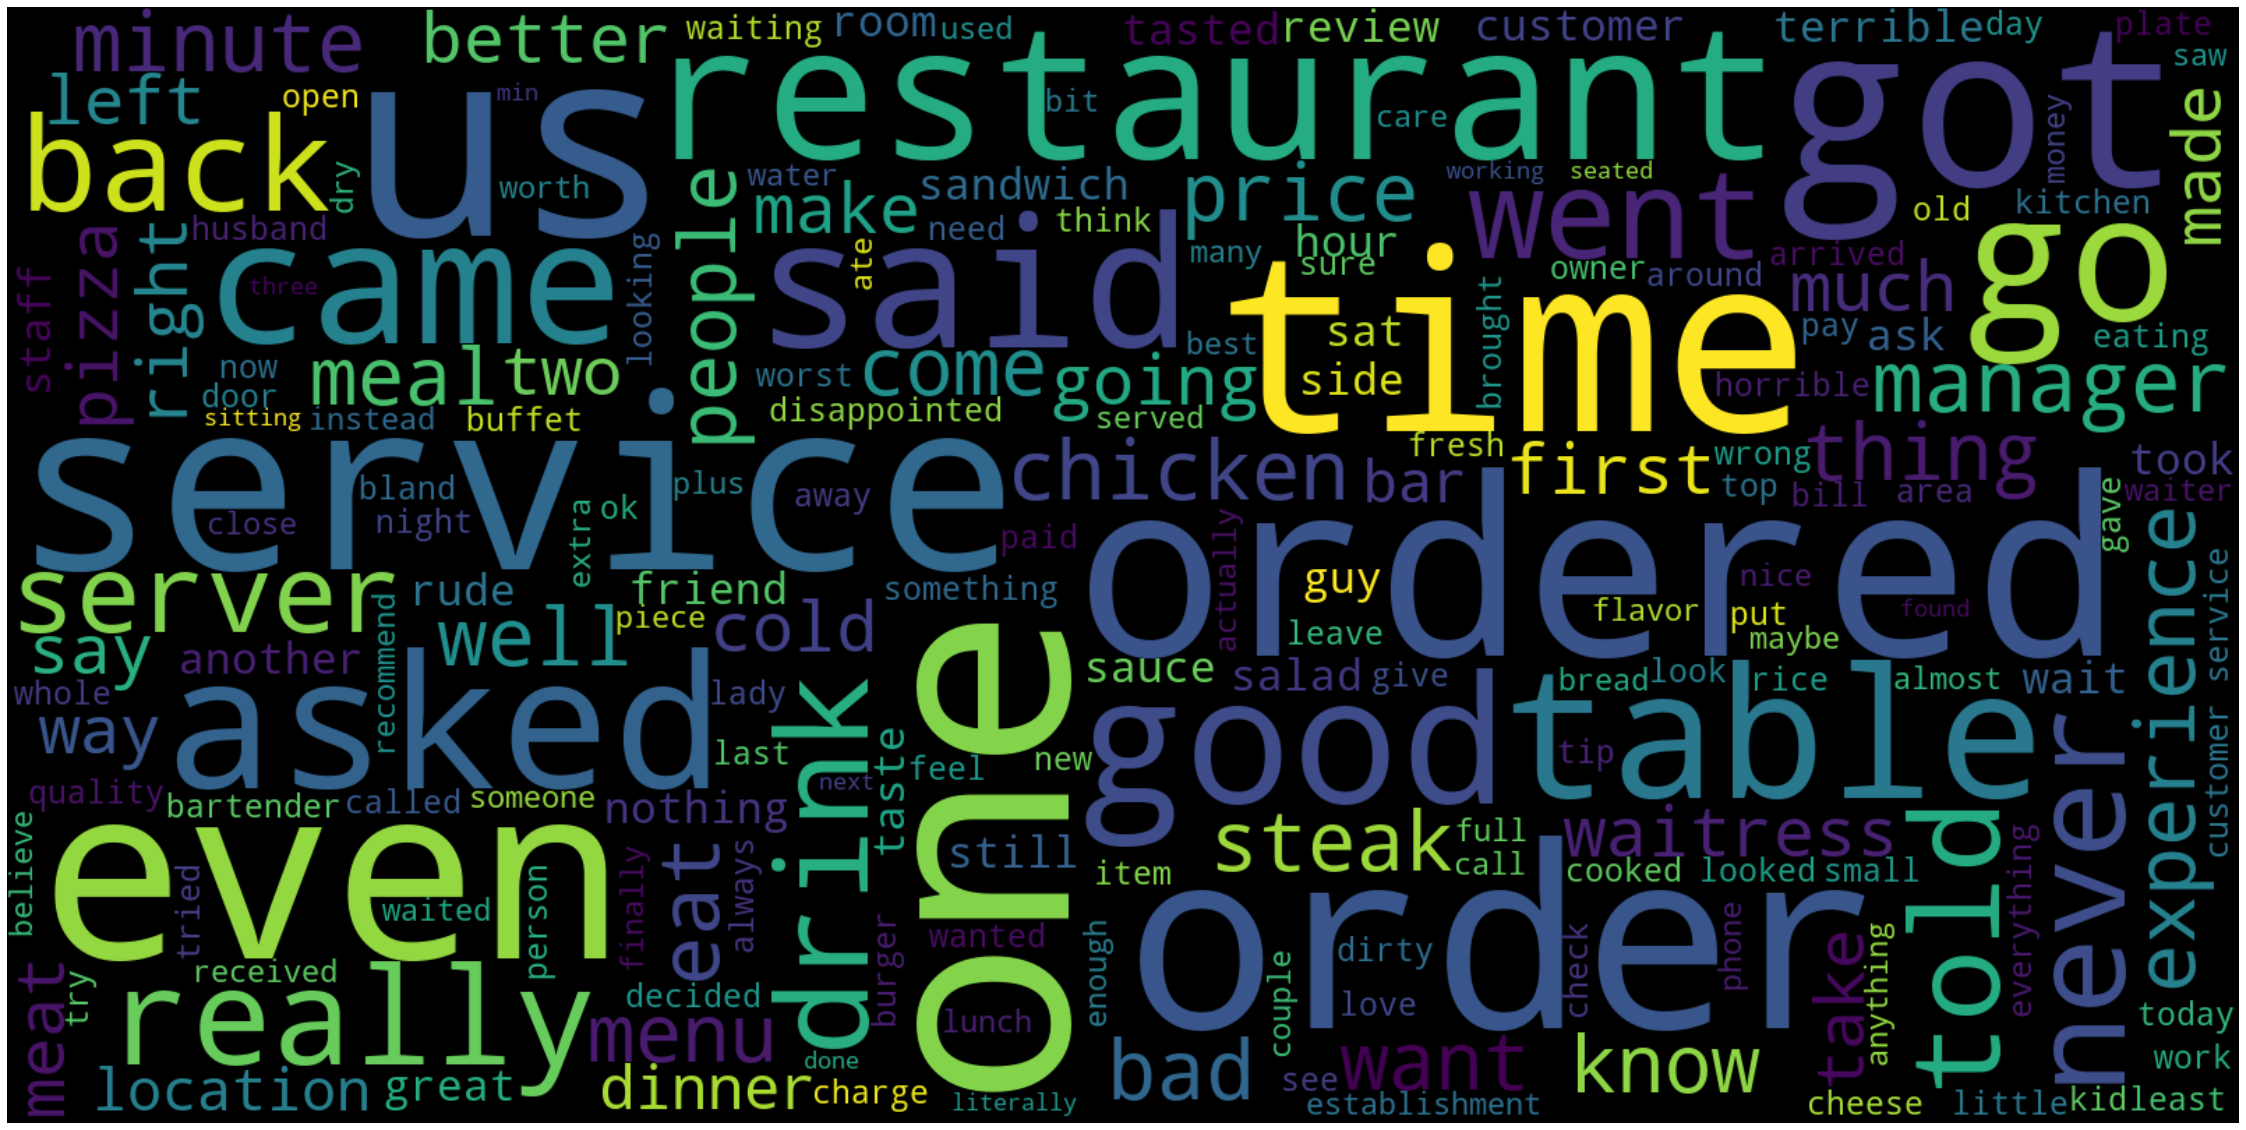

In [213]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

# Word Clouds with Count Vectorizer

In [192]:
cvector = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
cvector.fit(cloud_train_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [193]:
len(cvector.get_feature_names())

134907

## Positive Reviews

In [199]:
pos_matrix = cvector.transform(positive_reviews)
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])

In [221]:
print(type(pos_tf))
pos_tf.columns

<class 'pandas.core.frame.DataFrame'>


Index(['Terms', 'positive'], dtype='object')

In [236]:
positive_unique_terms = pos_tf[~pd.DataFrame(pos_tf.Terms.tolist()).isin(stopwords).any(1)]
positive_unique_terms[:20]

Terms  positive
22       great       223
26        good       187
29     and the       155
30     service       152
35      of the       139
37        time       119
39  this place       117
40        best       117
41  restaurant       116
43    the food       113
44         one       113
45   delicious       110
50      it was       104
51        back       103
54          ve        99
56          go        94
57        love        94
59    the best        92
61        well        87
63     amazing        86

## Negative Reviews

In [237]:
neg_matrix = cvector.transform(negative_reviews)
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

In [241]:
negative_unique_terms = neg_tf[~pd.DataFrame(neg_tf.Terms.tolist()).isin(stopwords).any(1)]
negative_unique_terms[:20]

Terms  negative
36      it was       177
38         one       173
40        back       170
41     service       170
43          us       164
48        time       147
49        even       144
52       order       134
53     ordered       134
55      of the       131
57  this place       130
58          go       130
60       never       128
61        came       126
62         don       125
66      in the       121
67         got       121
68        didn       117
72        good       112
73       asked       112

## Word Cloud with Tfidf

In [127]:
vectorizer = TfidfVectorizer()
tfidf_vtrain = vectorizer.fit_transform(cloud_train_data)
vocab = vectorizer.vocabulary_
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1))
tfidf_vtest = vectorizer.transform(positive_reviews)

In [196]:
# print(sorted_vocab)

In [ ]:
# Negative Reviews Dataset
negative_reviews = one_star.text[1600:2000].tolist()

In [66]:
# stopwords = STOPWORDS
# stopwords.add('will')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(cloud_test)

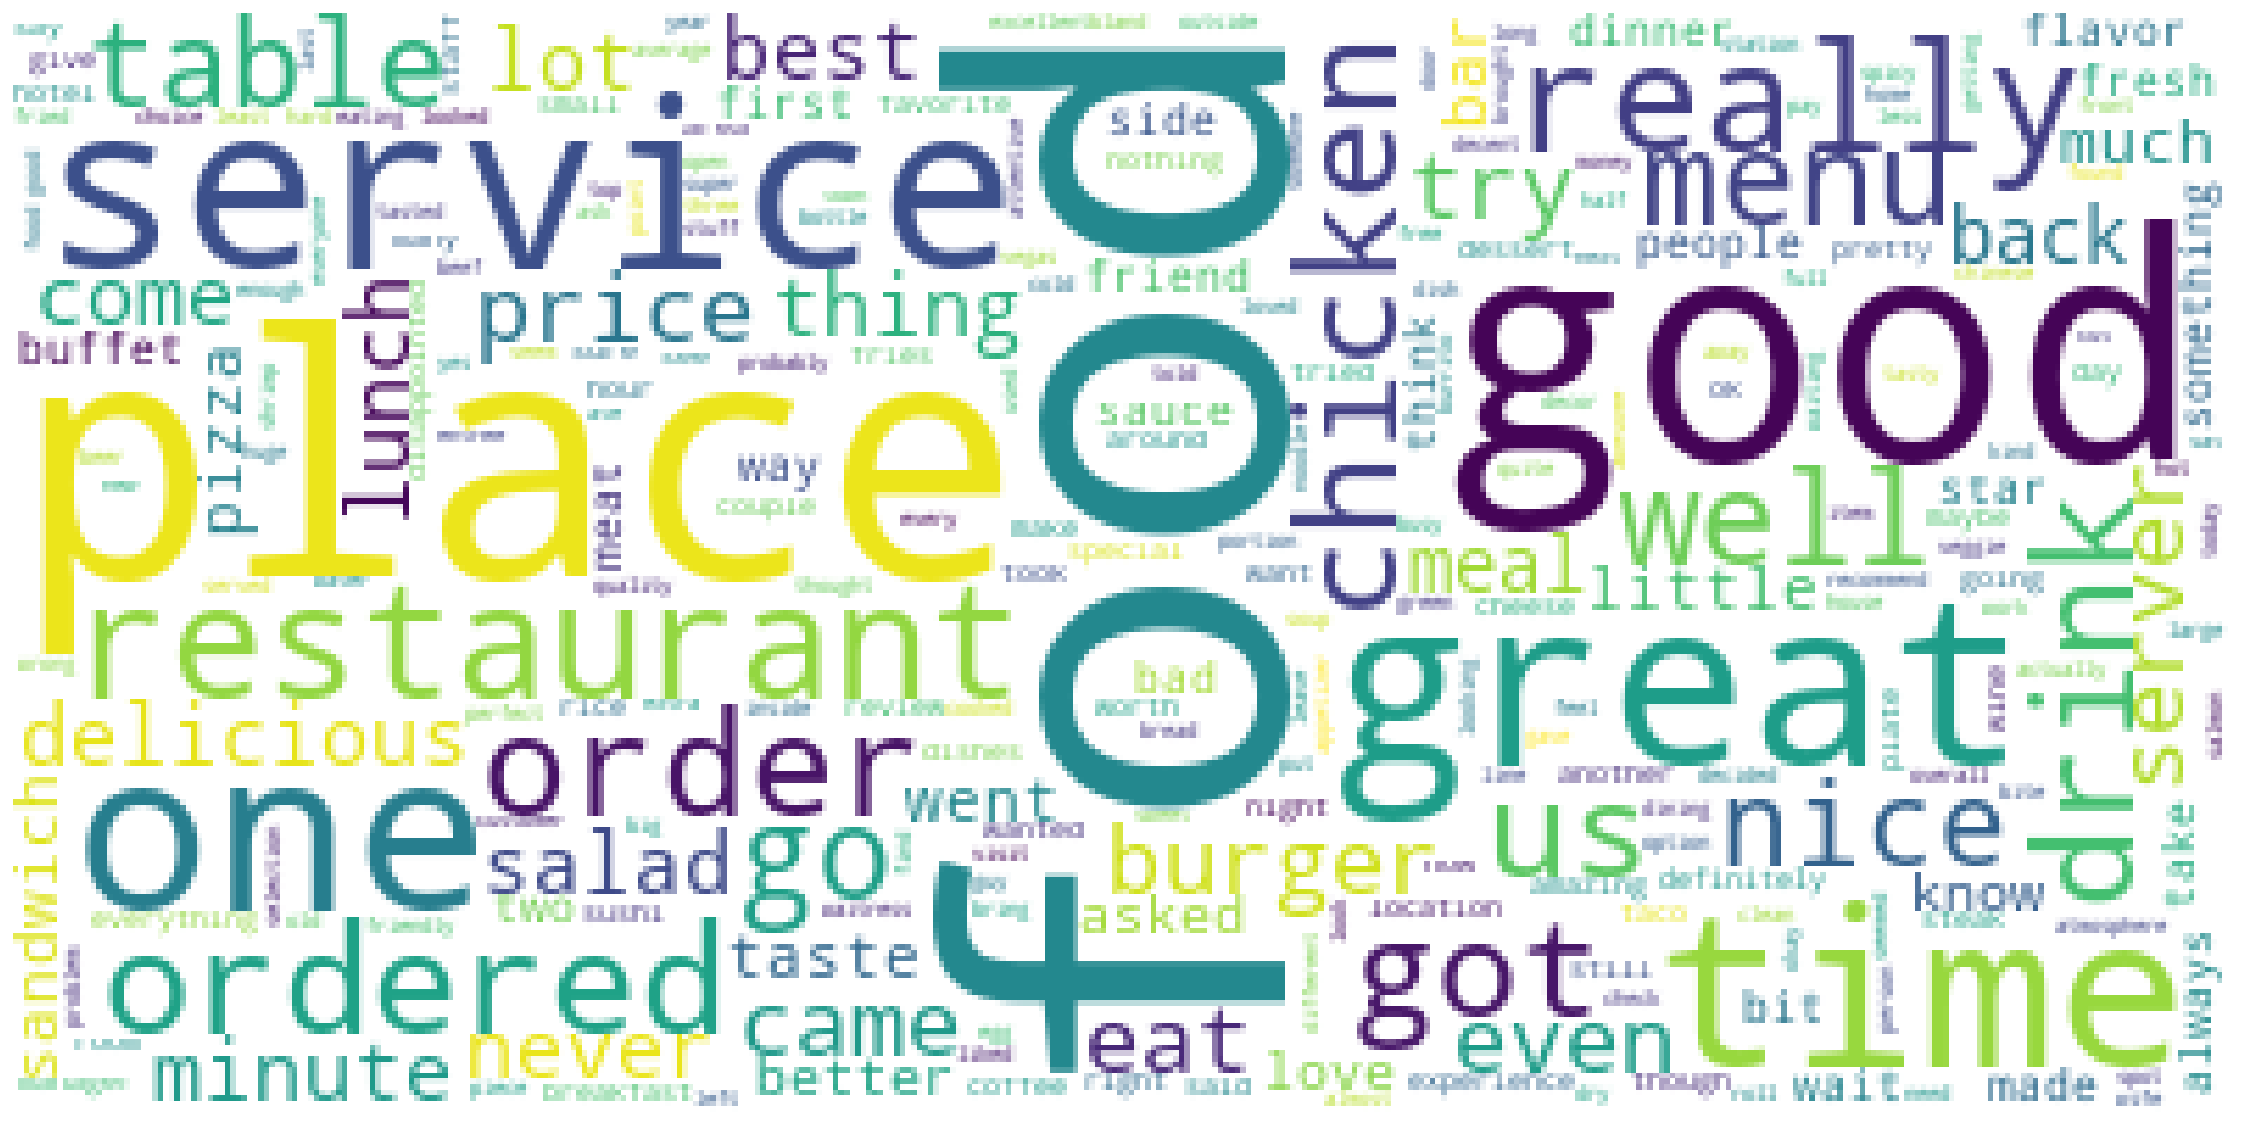

In [70]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

* Some positive words in the wordcloud for negative reviews may be an indicator of